In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
sns.set()

import warnings
warnings.filterwarnings("ignore")

#### 1/ Prepare features and labels to feed into the NER model

In [3]:
#import ingredients dataframe
nyt_ingredients=pd.read_csv("Data/nyt-ingredients.csv")

#drop nans
nyt_ingredients=nyt_ingredients[nyt_ingredients["name"].notna()]
nyt_ingredients=nyt_ingredients[nyt_ingredients["input"].notna()]

In [6]:
nyt_ingredients.head()

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


In [10]:
#filter ingredient names that are too long
filter=nyt_ingredients["name"].str.split().apply(lambda x : len(x))>4
nyt_ingredients=nyt_ingredients[~filter]

In [11]:
#create corpus of inputs and ingredients

inputs= [[word for word in gensim.utils.simple_preprocess(document)]
         for document in nyt_ingredients["input"]]

ingredients= [[word for word in gensim.utils.simple_preprocess(document)]
         for document in nyt_ingredients["name"]]


In [12]:
#Create dictionary
from gensim import corpora
dictionary = corpora.Dictionary(inputs)
dictionary.add_documents(ingredients)
dictionary.filter_extremes(no_below=2,no_above=1)

In [13]:
#Vectorize inputs and target ingredients
input_idx=[dictionary.doc2idx(input,unknown_word_index=len(dictionary)) for input in inputs]
ingredient_idx=[dictionary.doc2idx(ingredient,unknown_word_index=len(dictionary)) for ingredient in ingredients]

In [14]:
#Create labeled Target
labels=[]
for i in range(len(input_idx)) :
    NER=np.zeros(len(input_idx[i]))
    for j in range(len(input_idx[i])):
        if input_idx[i][j] in ingredient_idx[i] : 
            NER[j]=1
    labels.append(NER)


In [15]:
dictionary.save("ingredient_dictionary.gensim")

#### 2/ Create the the NER model

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [17]:
#Pad tokens (X var)    
maxlen = max([len(input) for input in input_idx ])
pad_input_idx = pad_sequences(input_idx, maxlen=maxlen, dtype='int32', padding='post', value= len(dictionary)+1)

In [18]:
#Specify dimensions to feed into LSTM model
input_dim = len(dictionary)+2
output_dim = 48
input_length = maxlen
n_tags = 2

In [19]:
#Pad Tags (y var) and convert it into one hot encoding
pad_labels = pad_sequences(labels, maxlen=maxlen, dtype='int32', padding='post', value= 0)
pad_labels = np.array([to_categorical(i, num_classes=n_tags) for i in pad_labels])

In [20]:
#Split train, test and validation set
inputs_, test_inputs, labels_, test_labels = train_test_split(pad_input_idx, pad_labels, test_size=0.1, train_size=0.9, random_state=2020)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs_,labels_,test_size = 0.25,train_size =0.75, random_state=2020)

In [21]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [103]:
def get_lstm_model():
    model = tf.keras.Sequential()

    # Add Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    
    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [23]:
model = get_bilstm_lstm_model()
history = model.fit(train_inputs, train_labels, epochs=2, batch_size=30, validation_data=(val_inputs,val_labels), verbose=1, shuffle=False)

Epoch 1/2
3906/3906 [==============================] - 249s 64ms/step - loss: 0.0270 - accuracy: 0.9897 - val_loss: 0.0174 - val_accuracy: 0.9935
Epoch 2/2
3906/3906 [==============================] - 285s 73ms/step - loss: 0.0174 - accuracy: 0.9936 - val_loss: 0.0169 - val_accuracy: 0.9937


In [44]:
pred=(model.predict(test_inputs)>0.5)*1
pred=pred[:,:,0]
test=test_labels[:,:,0]

In [29]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [46]:
print('Accuracy:', accuracy_score(pred,test))
print('F1 score:', f1_score(pred,test,average="micro"))
print('Recall:', recall_score(pred,test,average="micro"))
print('Precision:', precision_score(pred,test,average="micro"))

Accuracy: 0.8016590817443401
F1 score: 0.9966809277786337
Recall: 0.9958596285925245
Precision: 0.9975035827564409


In [31]:
pred=pred.reshape(-1)
test=test.reshape(-1)

In [32]:
print('Accuracy:', accuracy_score(pred,test))
print('F1 score:', f1_score(pred,test,average="macro"))
print('Recall:', recall_score(pred,test,average="macro"))
print('Precision:', precision_score(pred,test,average="macro"))

Accuracy: 0.9936216988171808
F1 score: 0.9576042864674781
Recall: 0.96668308917662
Precision: 0.9489027474332355


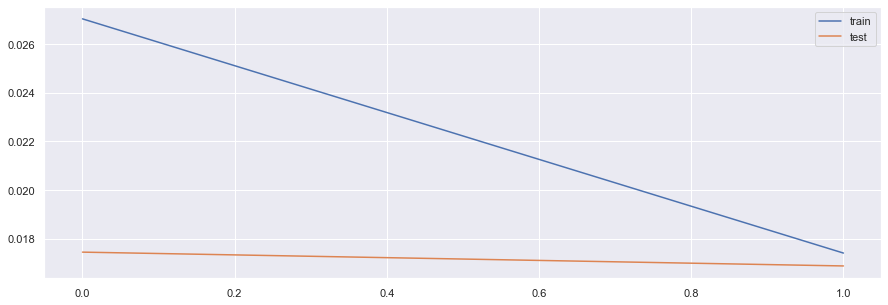

In [33]:
# plot history
plt.subplots(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [88]:
pred=(model.predict(test_inputs)>0.5)*1
pred=pred[:,:,1]
pred_ingredients=[test_inputs[i][(test_inputs*pred>0)[i]] for i in range(len(test_inputs))]
pred_ingredients=[[dictionary[ingredient_id] for ingredient_id in ingredient_array] for ingredient_array in pred_ingredients]

In [97]:
pred_ingredients

[['lingonberry', 'juice'],
 ['eggs'],
 ['onion'],
 ['chili', 'peppers'],
 ['olive', 'oil'],
 ['margarine'],
 ['seltzer'],
 ['lemon'],
 ['red', 'wine'],
 ['dry', 'yeast'],
 ['butter'],
 ['salt'],
 ['short', 'grain', 'rice'],
 ['peppermint', 'extract'],
 ['black', 'truffles'],
 ['mushrooms'],
 ['unsalted', 'butter', 'oil'],
 ['penne'],
 ['caraway', 'seeds'],
 ['lime', 'juice'],
 ['ghee'],
 ['water'],
 ['onion'],
 ['turbinado', 'sugar', 'sugar'],
 ['parmesan', 'cheese'],
 ['cream'],
 ['kabocha', 'squash'],
 ['pine', 'nuts'],
 ['red', 'onion'],
 ['olive', 'oil', 'spray'],
 ['butter'],
 ['anchovies'],
 ['onion'],
 ['loins', 'lamb'],
 ['sugar'],
 ['shiitake', 'mushrooms'],
 ['lemon', 'juice'],
 ['basil', 'leaves'],
 ['black', 'pepper'],
 ['dijon', 'mustard'],
 ['orange', 'juice'],
 ['muoc', 'mam'],
 ['dry', 'white', 'wine'],
 ['garlic'],
 ['basmati', 'rice'],
 ['scallions'],
 ['almonds'],
 ['kosher', 'salt'],
 ['unsalted', 'butter'],
 ['onion'],
 ['grains'],
 ['tomatoes'],
 ['worcestershire'

In [105]:
model.save('NER_model/NER_model.h5') 

In [120]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stemmer.stem("chopped")

'chop'

#### 3/ Applying Named Entity Recognition Model to Ingredient lists in order to extract Ingredient Names

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [57]:
#Load Recipes and Reviews DataFrames
recipes=pd.read_csv("recipes_clean.csv")
reviews=pd.read_csv("reviews_clean.csv")

In [70]:
recipes["Ingredients"]=recipes["Ingredients"].apply(eval)

In [74]:
recipes["Ingredients"]

0        [1/2 cup unsalted butter, chilled and cubed, 1...
1        [1/2 cup parmesan cheese, 3/4 teaspoon ground ...
2        [2 cups hot water, 1/2 cup margarine, 1/3 cup ...
3        [1 1/2 cups white sugar, 1/2 cup vegetable oil...
4        [1/4 cup butter, 1 teaspoon white sugar, 1 cup...
                               ...                        
48635    [1 cup corn syrup (such as karo®), 1 cup white...
48636    [4 cups whole milk, 1 tablespoon vanilla extra...
48637    [1 (16 ounce) package bacon, 1 head cauliflowe...
48638    [cooking spray, 3/4 cup milk, 1/2 cup white su...
48639    [1 (15 ounce) can pinto beans, rinsed and drai...
Name: Ingredients, Length: 48640, dtype: object

In [115]:
#Create inputs from ingredient lists to feed into NER model
#inputs=recipes["Ingredients"].str.split(",")
inputs=[[ingredient for ingredient in recipe] for recipe in recipes["Ingredients"]]

In [123]:
#Vectorize inputs and target ingredients
input_idx=[[dictionary.doc2idx(ingredient.split(" "),unknown_word_index=len(dictionary)) for ingredient in input] for input in inputs]

In [125]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [126]:
#Pad tokens (X var)    
maxlen = 43
pad_input_idx = [pad_sequences(input_idx[i], maxlen=maxlen, dtype='int32', padding='post', value= len(dictionary)+1) for i in range(len(input_idx))]

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('NER_model/NER_model.h5')

In [127]:
#predict ingredient list using model
ingredient_list=[(model.predict(pad_input_idx[i])<0.5)[:,:,0] for i in range(len(pad_input_idx))]

In [128]:
#remap predicted ingrent Id to ingredient name
ingredients=[[pad_input_idx[i][j][((pad_input_idx[i][j]*ingredient_list[i][j])>0)] for j in range(len(pad_input_idx[i]))] for i in range(len(pad_input_idx))]
ingredients=[[[dictionary[ingredient_id] for ingredient_id in ingredient_array] for ingredient_array in ingredient_list] for ingredient_list in ingredients]

In [130]:
#Lemmatize predicted ingredient list
lemma = nltk.wordnet.WordNetLemmatizer()
ingredient_list=[[[lemma.lemmatize(word) for word in words] for words in ingredient] for ingredient in ingredients]
ingredient_list=[[" ".join(words) for words in ingredient if len(words)>0] for ingredient in ingredient_list]

In [133]:
recipes

,Recipe_name,Rating,Prepare_time,Ingredients,Instructions,Ingredients_clean
0,"Basil, Roasted Peppers and Monterey Jack Cornb...",4.468085,100,"[1/2 cup unsalted butter, chilled and cubed, 1...",['preheat oven to 400 degrees f (205 degrees c...,"[unsalted, onion, cornmeal, flour, white sugar..."
1,Crispy Cheese Twists,4.431818,0,"[1/2 cup parmesan cheese, 3/4 teaspoon ground ...","['combine parmesan cheese, pepper and garlic p...","[parmesan cheese, black pepper, garlic powder,..."
2,Mom's Yeast Rolls,3.598837,0,"[2 cups hot water, 1/2 cup margarine, 1/3 cup ...",['melt margarine in hot water. add sugar and s...,"[water, margarine, white sugar, salt, water, d..."
3,Sweet Potato Bread I,4.707865,0,"[1 1/2 cups white sugar, 1/2 cup vegetable oil...",['combine sugar and oil; beat well. add eggs a...,"[white sugar, vegetable oil, egg, flour, bakin..."
4,Orange Buns,4.666667,170,"[1/4 cup butter, 1 teaspoon white sugar, 1 cup...",['stir butter and 1 teaspoon sugar into the ho...,"[butter, white sugar, milk, dry yeast, bread, ..."
...,...,...,...,...,...,...
48635,Chocolate Nutty Crispy Treats,5.000000,75,"[1 cup corn syrup (such as karo®), 1 cup white...",['mix corn syrup and sugar in a saucepan over ...,"[corn syrup, white sugar, chocolate chip, almo..."
48636,Simple Custard,5.000000,15,"[4 cups whole milk, 1 tablespoon vanilla extra...","['cook and stir milk, vanilla extract, and but...","[milk, vanilla extract, butter, egg, white sug..."
48637,Broccoli Cauliflower Salad,4.000000,95,"[1 (16 ounce) package bacon, 1 head cauliflowe...",['place bacon in a large skillet and cook over...,"[bacon, mozzarella cheese, white sugar, milk, ..."
48638,Whole Wheat Huckleberry Crumb Muffins,5.000000,35,"[cooking spray, 3/4 cup milk, 1/2 cup white su...",['preheat oven to 350 degrees f (175 degrees c...,"[spray, milk, white sugar, egg, vanilla extrac..."


In [136]:
#Add column to recipes DataFrame with cleaned ingredient list
recipes["Ingredients_clean"]=ingredient_list

#Add column with ratings
recipes=recipes[['Recipe_name','Rating','Prepare_time', 'Ingredients', 'Ingredients_clean','Instructions']]

In [137]:
#Save Cleaned Recipes
recipes.to_csv("recipes_clean.csv",index=False)